##DATASET preparation

In [ ]:
pip install obspy

In [ ]:
from obspy import Trace, Stream, UTCDateTime
import pandas as pd

df_fas = pd.read_csv('ESM_flatfile_FAS.csv', delimiter=';', nrows=50)  # Adjust the number of rows
df_sa = pd.read_csv('ESM_flatfile_SA.csv', delimiter=';', nrows=50)
df_sd = pd.read_csv('ESM_flatfile_SD.csv', delimiter=';', nrows=50)

# Merge FAS and SA datasets based on event_id
df_merged_fas_sa = pd.merge(df_fas, df_sa, on='event_id', how='inner')

# Merge the combined FAS-SA dataset with SD dataset based on event_id
df_combined = pd.merge(df_merged_fas_sa, df_sd, on='event_id', how='inner')

# Create ObsPy Stream
stream = Stream()

# Iterate over rows and create traces for each channel


In [ ]:
print(df_combined.columns)

Index(['event_id', 'event_time_x', 'ISC_ev_id_x', 'USGS_ev_id_x',
       'INGV_ev_id_x', 'EMSC_ev_id_x', 'ev_nation_code_x', 'ev_latitude_x',
       'ev_longitude_x', 'ev_depth_km_x',
       ...
       'rotD00_T3_000_y', 'rotD00_T3_500_y', 'rotD00_T4_000_y',
       'rotD00_T4_500_y', 'rotD00_T5_000_y', 'rotD00_T6_000_y',
       'rotD00_T7_000_y', 'rotD00_T8_000_y', 'rotD00_T9_000_y',
       'rotD00_T10_000_y'],
      dtype='object', length=1078)


In [ ]:
pip install matplotlib

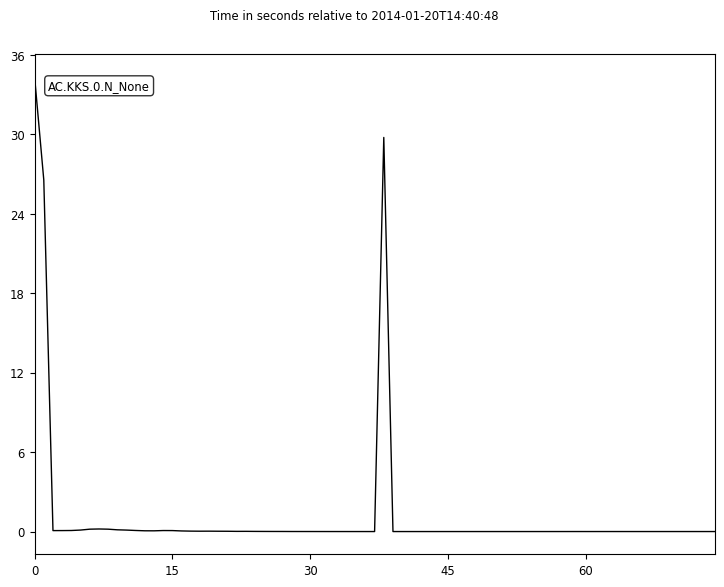

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Iterate over rows and create traces for each channel
for index, row in df_combined.iterrows():
    trace = Trace()
    trace.stats.network = row['network_code']
    # Assuming row is a DataFrame row
    trace.stats.station = str(row['station_code'])
    trace.stats.location = str(row['location_code'])
    trace.stats.channel = f"{row['V_channel_code']}_{row.get('frequency_hz', row.get('Frequency'))}"  # Adjust as needed
    trace.stats.starttime = UTCDateTime(row['event_time_x'])

    # Initialize an empty list to store waveform data
    waveform_data = []

    # Iterate over waveform data columns
    for col_name in df_combined.columns:
        if col_name.startswith('rotD00_T'):
            waveform_data.append(row[col_name])

    # Convert the list to a NumPy array
    trace.data = np.array(waveform_data, dtype=float)  # Adjust as needed

    # Add station metadata to trace metadata
    trace.stats.sac = {
        # Source to site distance metrics
        'epi_dist': row['epi_dist'],
        'epi_az': row['epi_az'],
        'JB_dist': row['JB_dist'],
        'rup_dist': row['rup_dist'],
        'Rx_dist': row['Rx_dist'],
        'Ry0_dist': row['Ry0_dist'],
        # Waveform metadata
        'instrument_type_code': row['instrument_type_code'],
        'late_triggered_flag_01': row['late_triggered_flag_01'],
        'V_channel_code': row['V_channel_code'],
        'V_azimuth_deg': row['V_azimuth_deg'],
        'V_hp': row['V_hp'],
        'V_lp': row['V_lp'],
        # Intensity measures
        'U_pga': row['U_pga'],
        'U_pgv': row['U_pgv'],
        'U_pgd': row['U_pgd'],
        'U_T90': row['U_T90'],
        'U_housner': row['U_housner'],
        'U_ia': row['U_ia'],
        'U_CAV': row['U_CAV'],
        'U_T0_010': UTCDateTime(row['event_time_x']),
        # Add more intensity measures as needed
    }

    stream.append(trace)

graph= stream[7]

# Plot the seismic data for the first trace
graph.plot(type='relative', color='black', size=(800, 600))
plt.show()


##PCA[final]

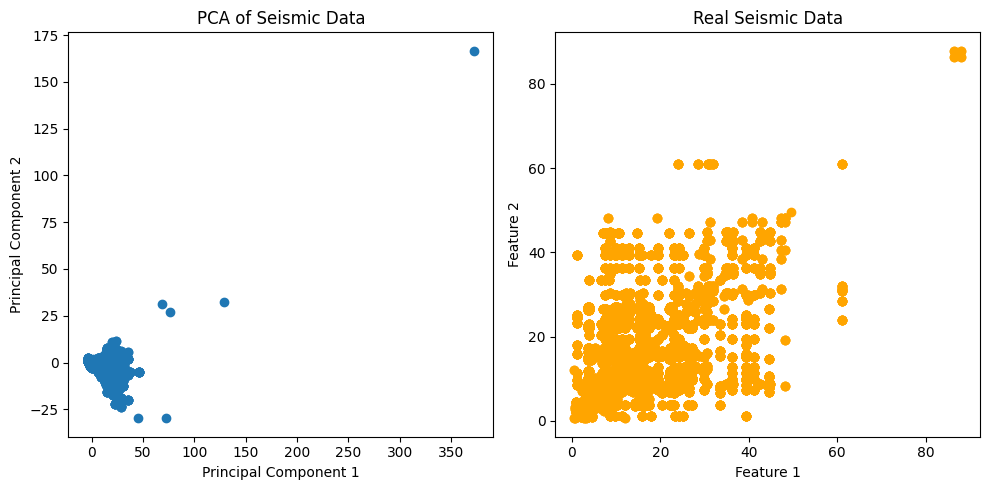

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming X contains your seismic data with NaN values
# Assuming real_data contains your real seismic data without NaN values

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(stream)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

# Plot the reduced data
plt.figure(figsize=(10, 5))

# Plot PCA reduced data
plt.subplot(121)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], label='Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Seismic Data')

# Plot real data
plt.subplot(122)
real_data = np.array([trace.data for trace in stream])
# Assuming real_data is a 2D array containing real seismic data
plt.scatter(real_data[:, 0], real_data[:, 1], label='Real Data', color='orange')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Real Seismic Data')

plt.tight_layout()
plt.show()



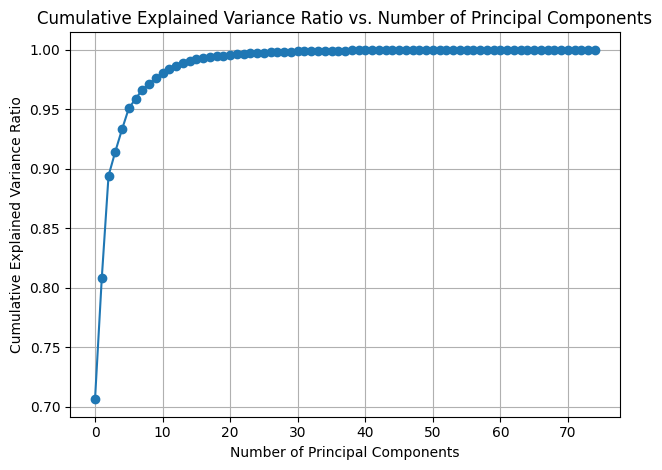

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()

##ICA[final]

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


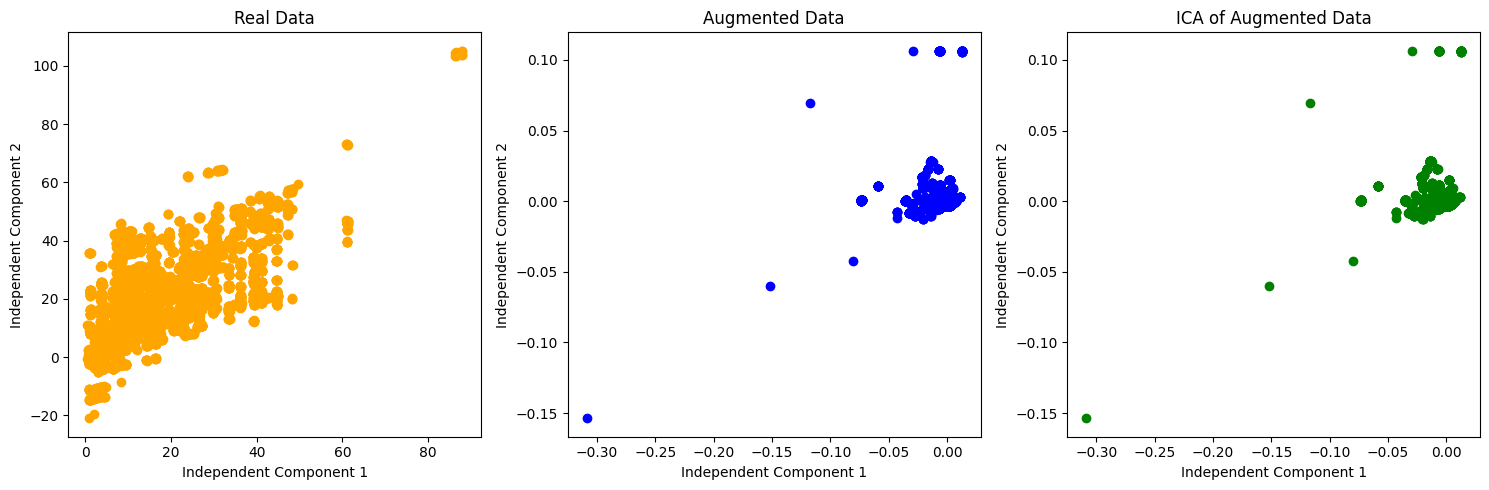

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.impute import SimpleImputer
from scipy.signal import resample_poly
# Step 1: Generate or load augmented data and real data
# For demonstration purposes, let's create some synthetic data
# Augmented data
def resample_data(data, target_length):
    resampled_data = resample_poly(data, target_length, len(data))
    return resampled_data

target_length = 100
X_augmented_array = Stream(traces=[Trace(data=resample_data(trace.data, target_length)) for trace in stream])  # Example augmented data (replace with your data)
# Convert Stream object to a NumPy array
X_augmented= np.array([trace.data for trace in X_augmented_array])

# Real data (corresponding to augmented data)
X_real = X_augmented + np.random.normal(0, 0.1, size=X_augmented.shape)

# Step 2: Preprocess the data to handle NaN values
# Create an imputer object
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the augmented data and transform it
X_augmented_imputed = imputer.fit_transform(X_augmented)
# Transform the real data using the same imputer
X_real_imputed = imputer.transform(X_real)

# Step 3: Apply Independent Component Analysis (ICA) for dimensionality reduction
ica = FastICA(n_components=2)
X_augmented_ica = ica.fit_transform(X_augmented_imputed)
X_real_ica = ica.transform(X_real_imputed)

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_real[:, 0], X_real[:, 1], color='orange')
plt.title('Real Data')
plt.xlabel('Independent Component 1')
plt.ylabel('Independent Component 2')


plt.subplot(1, 3, 2)
plt.scatter(X_real_ica[:, 0], X_real_ica[:, 1], color='blue')
plt.title('Augmented Data')
plt.xlabel('Independent Component 1')
plt.ylabel('Independent Component 2')

plt.subplot(1, 3, 3)
plt.scatter(X_augmented_ica[:, 0], X_augmented_ica[:, 1], color='green')
plt.title('ICA of Augmented Data')
plt.xlabel('Independent Component 1')
plt.ylabel('Independent Component 2')

plt.tight_layout()
plt.show()


## SVM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from obspy import Trace, Stream
from scipy.signal import resample_poly
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# Data Augmentation
# Example: Resampling as a simple data augmentation technique
def resample_data(data, target_length):
    resampled_data = resample_poly(data, target_length, len(data))
    return resampled_data

# Assuming 'event_id' is a unique identifier for each event
# Adjust test_size and random_state as needed
train_data, test_data = train_test_split(stream, test_size=0.2, random_state=42)

# Convert the DataFrames back to Stream for training
train_stream = Stream(traces=[Trace(data=np.array(row)) for row in train_data])
test_stream = Stream(traces=[Trace(data=np.array(row)) for row in test_data])

# Resample or pad the data to ensure a length of 1000
target_length = 1000
train_stream_resampled = Stream(traces=[Trace(data=resample_data(trace.data, target_length)) for trace in train_stream])
test_stream_resampled = Stream(traces=[Trace(data=resample_data(trace.data, target_length)) for trace in test_stream])

# Convert the Stream to a list of NumPy arrays for DataFrame creation
train_list = [np.array(trace.data) for trace in train_stream_resampled]
test_list = [np.array(trace.data) for trace in test_stream_resampled]

# Reshape the data to have a shape of (batch_size, 1000, 1)
train_array = np.expand_dims(np.array(train_list), axis=-1)
test_array = np.expand_dims(np.array(test_list), axis=-1)

# Reshape train and test arrays to 2D
train_array_2d = train_array.reshape(train_array.shape[0], -1)
test_array_2d = test_array.reshape(test_array.shape[0], -1)

# Rescale or Normalize Data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_array_2d)
test_scaled = scaler.transform(test_array_2d)

# Impute NaN values
imputer = SimpleImputer(strategy='mean')
train_scaled_2d_imputed = imputer.fit_transform(train_scaled)
test_scaled_2d_imputed = imputer.transform(test_scaled)

"""# Train SVM classifier
svm_model = SVC(kernel='rbf', gamma='scale', random_state=42)
svm_model.fit(train_scaled_2d_imputed, [1] * len(train_data) + [0] * len(train_data))  # Assuming all data in train_data is actual earthquake data"""

num_samples = len(train_scaled_2d_imputed)
num_quake_samples = num_samples // 2
num_non_quake_samples = num_samples - num_quake_samples

target_labels = [1] * num_quake_samples + [0] * num_non_quake_samples

num_samples_test = len(test_scaled_2d_imputed)
num_quake_samples_test = num_samples_test // 2
num_non_quake_samples_test = num_samples_test - num_quake_samples_test

y_true = [1] * num_quake_samples_test + [0] * num_non_quake_samples_test


# Train SVM classifier
svm_model = SVC(kernel='rbf', gamma='scale', random_state=42)
svm_model.fit(train_scaled_2d_imputed, target_labels)

# Predict on test set
y_pred = svm_model.predict(test_scaled_2d_imputed)

# Assuming the first half of test_data is actual earthquake data and the second half is augmented data
# Create true labels
y_true = [1] * (len(test_data) // 2) + [0] * (len(test_data) // 2)

# Ensure y_pred has the same length as y_true
y_pred_adjusted = y_pred[:len(y_true)]

# Evaluate model
accuracy = accuracy_score(y_true, y_pred_adjusted)
print("Test Accuracy:", accuracy)



Test Accuracy: 0.5082644628099173


** GRAPH**



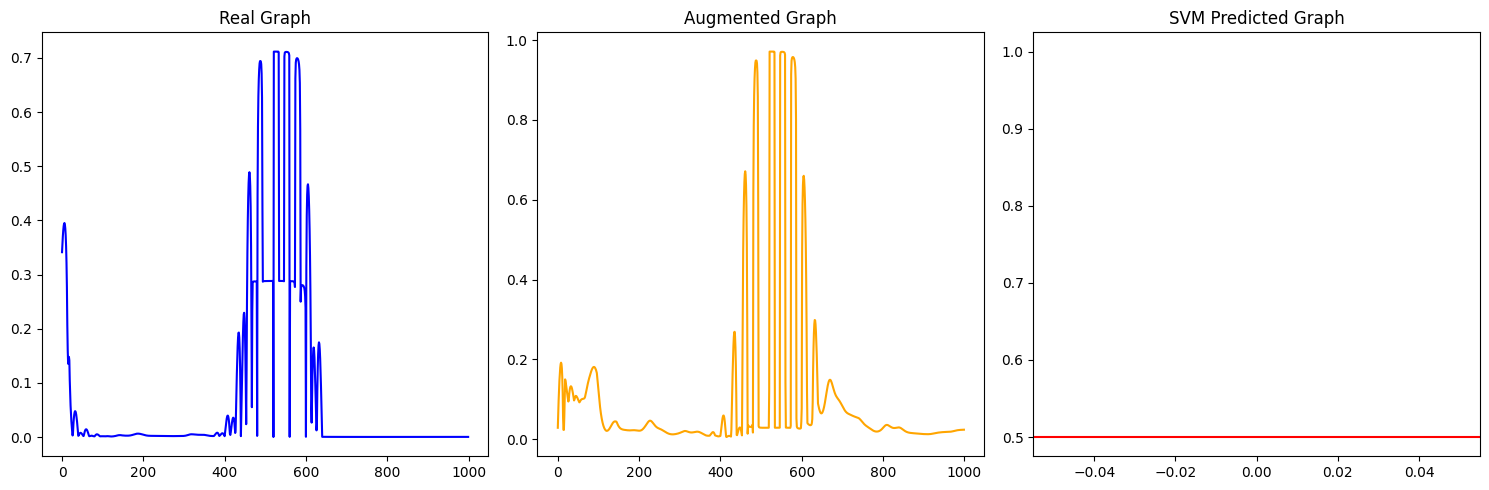

Predicted Labels: [1]


In [ ]:
import matplotlib.pyplot as plt

# Plot Real Graph
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(test_scaled_2d_imputed[1], color='blue')  # Plot the first sample from test data
plt.title('Real Graph')

# Plot Augmented Graph
plt.subplot(132)
plt.plot(test_scaled_2d_imputed[num_samples_test // 2], color='orange')  # Plot the first augmented sample from test data
plt.title('Augmented Graph')

# Plot SVM Predicted Graph for a specific data point (e.g., the first data point)
plt.subplot(133)

# Predict with SVM model for the first data point
predicted_data = svm_model.predict(test_scaled_2d_imputed[1].reshape(1, -1))

# Plot predicted graph for the first data point
plt.plot(predicted_data, color='green')
plt.axhline(y=0.5, color='red', linestyle='-')
plt.title('SVM Predicted Graph')

plt.tight_layout()
plt.show()

print("Predicted Labels:", predicted_data)

In [ ]:
# Predict on test set
y_pred = svm_model.predict(test_scaled_2d_imputed)

# Print the predicted data
print("Predicted Labels:", y_pred)


Predicted Labels: [0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0
 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1
 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1
 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0
 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1
 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1]


##GAN

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(stream)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the Generator model
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=latent_dim, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(X_scaled.shape[1], activation='tanh')) # Output layer
    return model

# Define the Discriminator model
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(512, input_shape=input_shape, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # Output layer
    return model

# Combine Generator and Discriminator into a GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    generated_data = generator(gan_input)
    gan_output = discriminator(generated_data)
    gan = models.Model(gan_input, gan_output)
    return gan

# Define hyperparameters
latent_dim = 100
epochs = 1000
batch_size = 32

# Build and compile the Discriminator
discriminator = build_discriminator((X_scaled.shape[1],))
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

# Build the Generator
generator = build_generator(latent_dim)

# Build and compile the GAN model
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))


# Training loop
for epoch in range(epochs):
    # Generate random noise as input to the Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate fake data with Generator
    generated_data = generator.predict(noise)

    # Select a random batch of real data from the X_scaled dataset
    idx = np.random.randint(0, X_scaled.shape[0], batch_size)
    real_data = X_scaled[idx]

    # Concatenate real data and generated data to create the training dataset for the Discriminator
    X_combined = np.concatenate([real_data, generated_data])

    # Labels for the real and generated data
    y_real = np.ones((batch_size, 1))
    y_generated = np.zeros((batch_size, 1))

    # Train the Discriminator
    d_loss_real = discriminator.train_on_batch(real_data, y_real)
    d_loss_generated = discriminator.train_on_batch(generated_data, y_generated)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_generated)

    # Generate new random noise as input to the GAN
    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Labels for the generated data (pretending it's real)
    y_generated = np.ones((batch_size, 1))

    # Train the Generator via the GAN model
    g_loss = gan.train_on_batch(noise, y_generated)

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}")


1/1 [==============================] - 0s 289ms/step
Epoch 0, Discriminator Loss: 0.7431651055812836, Generator Loss: 0.6210469007492065
1/1 [==============================] - 0s 49ms/step
Epoch 100, Discriminator Loss: 0.1374056562781334, Generator Loss: 3.6136507987976074
1/1 [==============================] - 0s 20ms/step
Epoch 200, Discriminator Loss: 0.8123783767223358, Generator Loss: 2.1415486335754395
1/1 [==============================] - 0s 23ms/step
Epoch 300, Discriminator Loss: 0.07072095759212971, Generator Loss: 3.8229923248291016
1/1 [==============================] - 0s 20ms/step
Epoch 400, Discriminator Loss: 0.026765362825244665, Generator Loss: 5.564676284790039
1/1 [==============================] - 0s 19ms/step
Epoch 500, Discriminator Loss: 0.004332542885094881, Generator Loss: 7.2726030349731445
1/1 [==============================] - 0s 19ms/step
Epoch 600, Discriminator Loss: 0.004948405083268881, Generator Loss: 5.984170913696289
1/1 [=========================

**Graph**

1/1 [==============================] - 0s 19ms/step


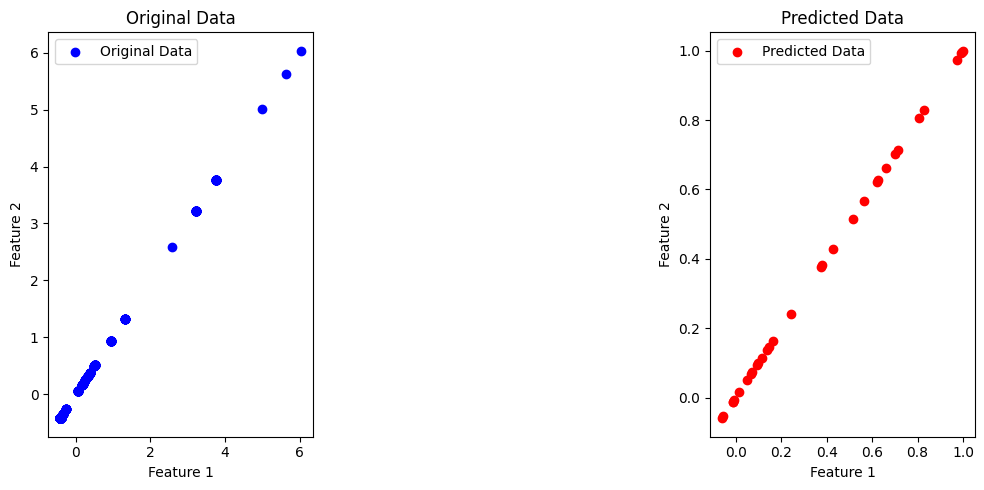

Predicted Labels: [-1.         -1.          0.9997985   0.99999446  0.9999951   0.99943537
  0.9999716   0.9999995   0.8081596   0.87933624  0.9999631   1.
  1.          1.          1.          1.          1.          0.99998045
  0.9999995   0.99989605 -0.4123916   0.6430309   0.99174976  0.8954335
  0.82772905 -0.37821373  0.98148024  0.9991192   0.9981265   0.999851
  0.9739128  -0.9452748   0.757379    0.9975403   0.9800549   0.6984846
  0.97418     0.99147594 -1.          0.5242027   0.99743986  0.98213273
 -0.72550267 -0.40025726  0.8350555   0.9057436   0.9819325  -0.52597064
  1.          1.          1.          1.          1.          0.99999857
  0.99988556  0.9998789   0.99991804  0.9997516   0.99815995  0.96725225
  0.9976952   0.9827458   0.9945958   0.9608677   0.9142683   0.99359256
  0.8595799   0.6402262   0.9950833   0.9700103   0.7837813   0.98653793
  0.9594951   0.9992927   0.99815124]


In [ ]:
import matplotlib.pyplot as plt

# Assuming original_data, augmented_data, and predicted_data are arrays containing your data

# Plot original data
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 2], X_scaled[:, 2], c='blue', label='Original Data')
plt.title('Original Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()



# Plot predicted data
predicted_data = generator.predict(noise)
plt.subplot(1, 3, 3)
plt.scatter(predicted_data[:, 2], predicted_data[:, 2], c='red', label='Predicted Data')
plt.title('Predicted Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()
print("Predicted Labels:", predicted_data[2])

#LSTM

In [ ]:
pip install obspy

In [ ]:
from obspy import Trace, Stream, UTCDateTime
import pandas as pd

df_fas = pd.read_csv('ESM_flatfile_FAS.csv', delimiter=';', nrows=50)  # Adjust the number of rows
df_sa = pd.read_csv('ESM_flatfile_SA.csv', delimiter=';', nrows=50)
df_sd = pd.read_csv('ESM_flatfile_SD.csv', delimiter=';', nrows=50)

# Merge FAS and SA datasets based on event_id
df_merged_fas_sa = pd.merge(df_fas, df_sa, on='event_id', how='inner')

# Merge the combined FAS-SA dataset with SD dataset based on event_id
df_combined = pd.merge(df_merged_fas_sa, df_sd, on='event_id', how='inner')

# Create ObsPy Stream
stream = Stream()



In [ ]:
pip install matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Iterate over rows and create traces for each channel
for index, row in df_combined.iterrows():
    trace = Trace()
    trace.stats.network = row['network_code']
    # Assuming row is a DataFrame row
    trace.stats.station = str(row['station_code'])
    trace.stats.location = str(row['location_code'])
    trace.stats.channel = f"{row['V_channel_code']}_{row.get('frequency_hz', row.get('Frequency'))}"  # Adjust as needed
    trace.stats.starttime = UTCDateTime(row['event_time_x'])

    # Initialize an empty list to store waveform data
    waveform_data = []

    # Iterate over waveform data columns
    for col_name in df_combined.columns:
        if col_name.startswith('rotD00_T'):
            waveform_data.append(row[col_name])

    # Convert the list to a NumPy array
    trace.data = np.array(waveform_data, dtype=float)  # Adjust as needed

    # Add station metadata to trace metadata
    trace.stats.sac = {
        # Source to site distance metrics
        'epi_dist': row['epi_dist'],
        'epi_az': row['epi_az'],
        'JB_dist': row['JB_dist'],
        'rup_dist': row['rup_dist'],
        'Rx_dist': row['Rx_dist'],
        'Ry0_dist': row['Ry0_dist'],
        # Waveform metadata
        'instrument_type_code': row['instrument_type_code'],
        'late_triggered_flag_01': row['late_triggered_flag_01'],
        'V_channel_code': row['V_channel_code'],
        'V_azimuth_deg': row['V_azimuth_deg'],
        'V_hp': row['V_hp'],
        'V_lp': row['V_lp'],
        # Intensity measures
        'U_pga': row['U_pga'],
        'U_pgv': row['U_pgv'],
        'U_pgd': row['U_pgd'],
        'U_T90': row['U_T90'],
        'U_housner': row['U_housner'],
        'U_ia': row['U_ia'],
        'U_CAV': row['U_CAV'],
        'U_T0_010': UTCDateTime(row['event_time_x']),
        # Add more intensity measures as needed
    }

    stream.append(trace)



In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(stream)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

In [ ]:
# Extract waveform data from the stream
waveform_data = [trace.data for trace in stream]

# Convert waveform_data to a NumPy array
X = np.array(waveform_data)

# Reshape X if needed. It should be of shape (number_of_traces, length_of_each_trace)

# Now you can proceed with imputation and scaling
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)




In [ ]:
import numpy as np

# Assuming X_scaled is your feature matrix
# Generate random labels (y) with values 0 or 1
y = np.random.randint(2, size=X_scaled.shape[0])



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape the input data for LSTM
seq_length = 25  # Define the sequence length
X_train_reshaped = X_train.reshape((X_train.shape[0], seq_length, -1))
X_test_reshaped = X_test.reshape((X_test.shape[0], seq_length, -1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(seq_length, X_train_reshaped.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
25/25 [==============================] - 9s 125ms/step - loss: 0.6915 - accuracy: 0.5232 - val_loss: 0.6926 - val_accuracy: 0.5179
Epoch 2/10
25/25 [==============================] - 1s 30ms/step - loss: 0.6911 - accuracy: 0.5567 - val_loss: 0.6945 - val_accuracy: 0.5026
Epoch 3/10
25/25 [==============================] - 1s 26ms/step - loss: 0.6899 - accuracy: 0.5374 - val_loss: 0.6936 - val_accuracy: 0.5179
Epoch 4/10
25/25 [==============================] - 1s 25ms/step - loss: 0.6897 - accuracy: 0.5477 - val_loss: 0.6927 - val_accuracy: 0.5333
Epoch 5/10
25/25 [==============================] - 1s 25ms/step - loss: 0.6888 - accuracy: 0.5464 - val_loss: 0.6936 - val_accuracy: 0.5231
Epoch 6/10
25/25 [==============================] - 1s 24ms/step - loss: 0.6888 - accuracy: 0.5335 - val_loss: 0.6951 - val_accuracy: 0.5128
Epoch 7/10
25/25 [==============================] - 1s 26ms/step - loss: 0.6886 - accuracy: 0.5451 - val_loss: 0.6940 - val_accuracy: 0.5333
Epoch 8/10
2

8/8 [==============================] - 0s 5ms/step


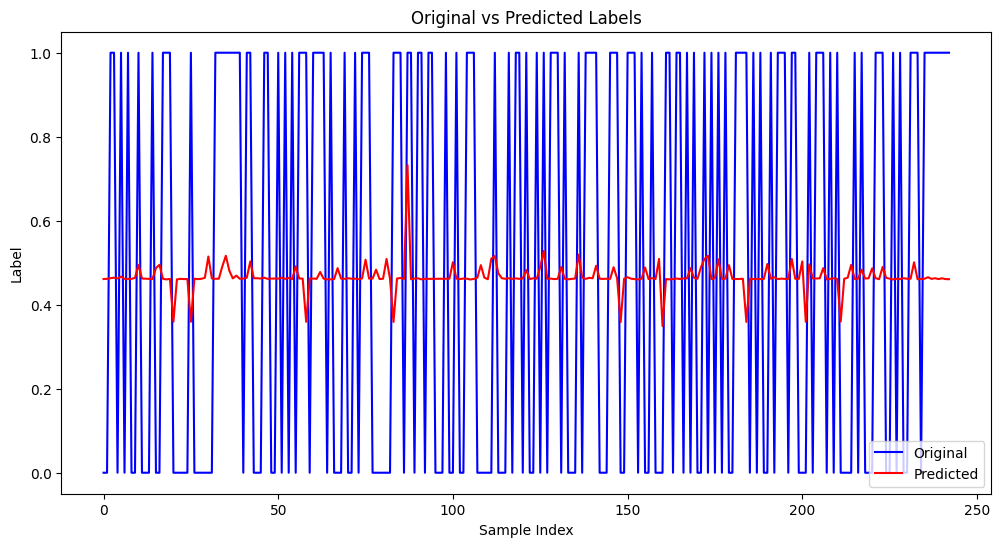

In [ ]:
import matplotlib.pyplot as plt

# Predict using the test data
y_pred = model.predict(X_test_reshaped)

# Plot original and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Original', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Original vs Predicted Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.legend()
plt.show()
